In [ ]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

mv: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [ ]:
!kaggle datasets download -d jonathanoheix/face-expression-recognition-dataset

Dataset URL: https://www.kaggle.com/datasets/jonathanoheix/face-expression-recognition-dataset
License(s): unknown
face-expression-recognition-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!unzip /content/face-expression-recognition-dataset.zip

Archive:  /content/face-expression-recognition-dataset.zip
replace images/images/train/angry/0.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
import os
import cv2
import numpy as np

def load_images_and_labels(directory):
  images = []
  labels = []
  for label in os.listdir(directory):
    label_directory = os.path.join(directory, label)
    if os.path.isdir(label_directory):
      for filename in os.listdir(label_directory):
        img_path = os.path.join(label_directory, filename)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is not None:
          images.append(img)
          labels.append(label)
  return np.array(images), np.array(labels)


train_images, train_labels = load_images_and_labels('/content/images/images/train')
validation_images, validation_labels = load_images_and_labels('/content/images/images/validation')

print("Train images shape:", train_images.shape)
print("Train labels shape:", train_labels.shape)
print("Validation images shape:", validation_images.shape)
print("Validation labels shape:", validation_labels.shape)


Train images shape: (28821, 48, 48)
Train labels shape: (28821,)
Validation images shape: (7066, 48, 48)
Validation labels shape: (7066,)


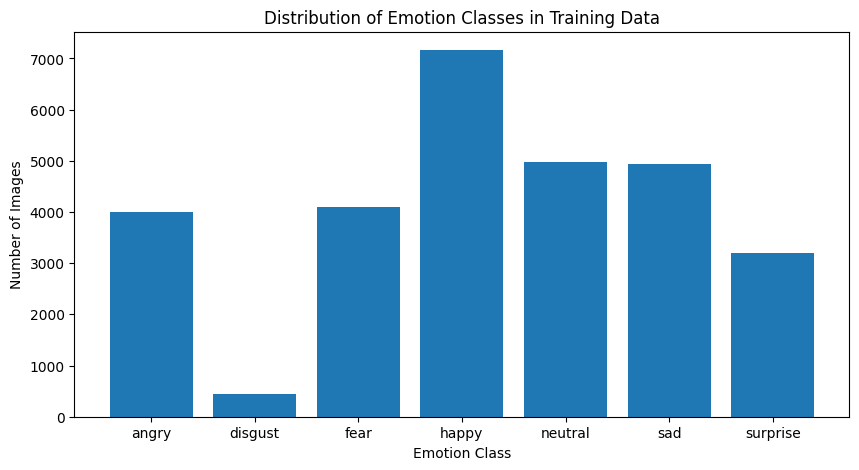

In [ ]:
import matplotlib.pyplot as plt

unique_labels, label_counts = np.unique(train_labels, return_counts=True)

plt.figure(figsize=(10, 5))
plt.bar(unique_labels, label_counts)
plt.xlabel("Emotion Class")
plt.ylabel("Number of Images")
plt.title("Distribution of Emotion Classes in Training Data")
plt.show()


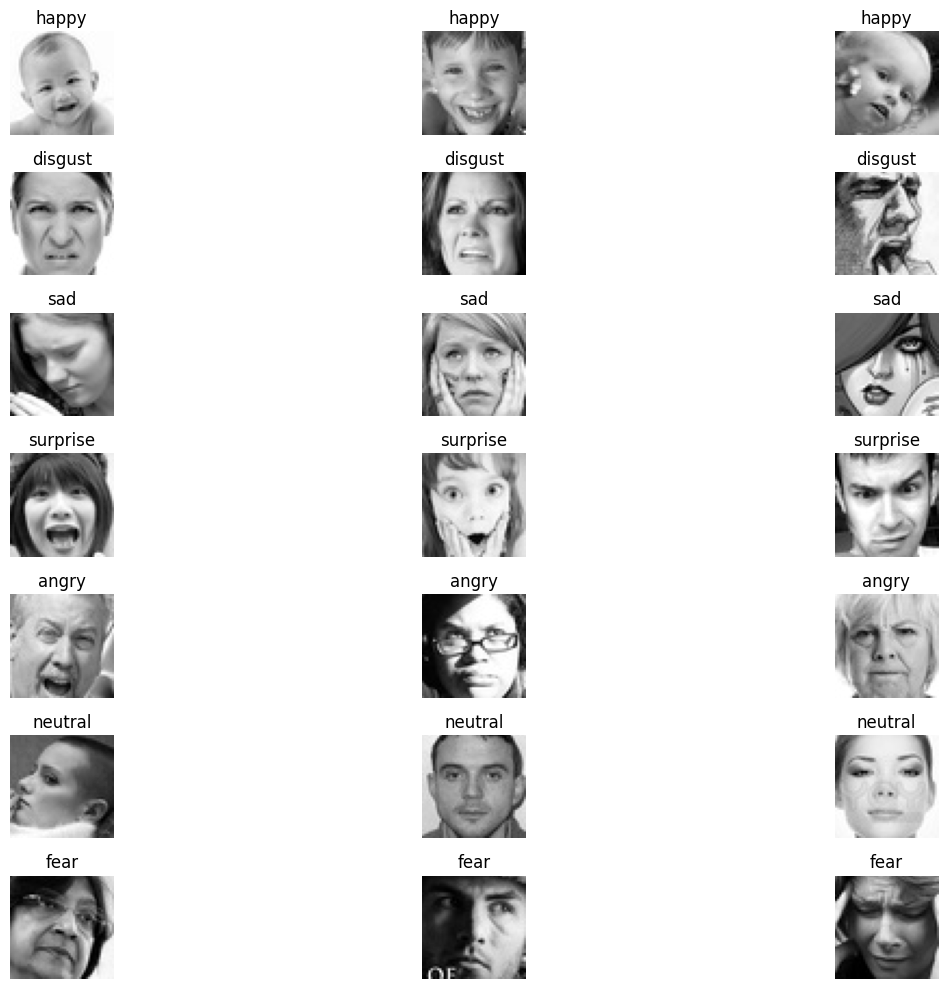

In [ ]:

num_images_per_class = 3

# Create a dictionary to store images for each class
images_by_class = {}

# Iterate through the training data and store images for each class
for i in range(len(train_images)):
  label = train_labels[i]
  if label not in images_by_class:
    images_by_class[label] = []
  if len(images_by_class[label]) < num_images_per_class:
    images_by_class[label].append(train_images[i])


# Create a figure and subplots for displaying the images
plt.figure(figsize=(15, 10))
subplot_index = 1

# Iterate through the classes and display the selected images
for label, images in images_by_class.items():
  for image in images:
    plt.subplot(len(images_by_class), num_images_per_class, subplot_index)
    plt.imshow(image, cmap='gray')
    plt.title(label)
    plt.axis('off')
    subplot_index += 1

plt.tight_layout()
plt.show()


In [ ]:
unique_labels = np.unique(train_labels)
label_to_numeric = {label: i for i, label in enumerate(unique_labels)}

print("Label to Numeric Mapping:")
for label, numeric_value in label_to_numeric.items():
  print(f"{label}: {numeric_value}")

train_labels_numeric = [label_to_numeric[label] for label in train_labels]
validation_labels_numeric = [label_to_numeric[label] for label in validation_labels]



Label to Numeric Mapping:
angry: 0
disgust: 1
fear: 2
happy: 3
neutral: 4
sad: 5
surprise: 6


In [ ]:
def resize_images(images, size=(48, 48)):
  resized_images = []
  for image in images:
    resized_image = cv2.resize(image, size, interpolation=cv2.INTER_AREA)
    resized_images.append(resized_image)
  return np.array(resized_images)

train_images_resized = resize_images(train_images)
validation_images_resized = resize_images(validation_images)

print("Resized Train images shape:", train_images_resized.shape)
print("Resized Validation images shape:", validation_images_resized.shape)


Resized Train images shape: (28821, 48, 48)
Resized Validation images shape: (7066, 48, 48)


In [ ]:
train_images_normalized = train_images_resized / 255.0


print("Normalized Train images shape:", train_images_normalized.shape)


Normalized Train images shape: (28821, 48, 48)


In [ ]:
from imblearn.over_sampling import RandomOverSampler
from collections import Counter

ros = RandomOverSampler(random_state=42)
train_images_balanced, train_labels_balanced = ros.fit_resample(
    train_images_normalized.reshape(-1, 48 * 48), np.array(train_labels_numeric)
)

train_images_balanced = train_images_balanced.reshape(-1, 48, 48, 1)

print("Balanced Train images shape:", train_images_balanced.shape)
print("Balanced Train labels shape:", train_labels_balanced.shape)

numeric_label_counts_balanced = Counter(train_labels_balanced)

print("Balanced Numeric Label Counts:")
for label, count in numeric_label_counts_balanced.items():
  print(f"Label {label}: {count} images")


Balanced Train images shape: (50148, 48, 48, 1)
Balanced Train labels shape: (50148,)
Balanced Numeric Label Counts:
Label 3: 7164 images
Label 1: 7164 images
Label 5: 7164 images
Label 6: 7164 images
Label 0: 7164 images
Label 4: 7164 images
Label 2: 7164 images


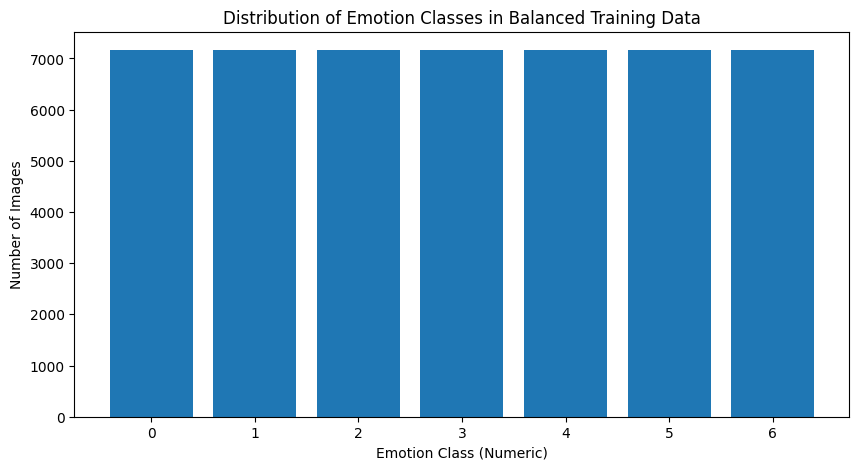

In [ ]:
plt.figure(figsize=(10, 5))
plt.bar(numeric_label_counts_balanced.keys(), numeric_label_counts_balanced.values())
plt.xlabel("Emotion Class (Numeric)")
plt.ylabel("Number of Images")
plt.title("Distribution of Emotion Classes in Balanced Training Data")
plt.show()


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


In [ ]:

#one-hot encode your labels:
num_classes = 7  # Number of classes (0-6)
train_labels_balanced = to_categorical(train_labels_balanced, num_classes)


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(train_images_balanced, train_labels_balanced, test_size=0.2, random_state=42)


In [ ]:
from tensorflow.keras.layers import BatchNormalization

model2 = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 1)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    layers.Conv2D(256, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:

model2.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 46, 46, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 46, 46, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 23, 23, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 23, 23, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 21, 21, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 21, 21, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 10, 10, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 10, 10, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 8, 8, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 8, 8, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 2, 2, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 2, 2, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 1, 1, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 1, 1, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │              

 Total params: 424,071 (1.62 MB)

 Trainable params: 422,855 (1.61 MB)

 Non-trainable params: 1,216 (4.75 KB)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='val_loss',      # Monitor validation loss
    patience=5,              # Number of epochs with no improvement to wait before stopping
    restore_best_weights=True # Restore model weights from the epoch with the best validation loss
)
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',      # Monitor validation loss
    factor=0.2,              # Factor by which the learning rate will be reduced
    patience=3,              # Number of epochs with no improvement to wait before reducing learning rate
    min_lr=1e-6              # Lower bound on the learning rate
)


In [ ]:

model2.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
history2 = model2.fit(X_train, y_train, epochs=50, batch_size=32,
                    validation_data=(X_val, y_val),
                    callbacks=[early_stopping, reduce_lr])

Epoch 1/50
1254/1254 ━━━━━━━━━━━━━━━━━━━━ 27s 12ms/step - accuracy: 0.2120 - loss: 2.3201 - val_accuracy: 0.4252 - val_loss: 1.5395 - learning_rate: 0.0010
Epoch 2/50
1254/1254 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.4106 - loss: 1.5497 - val_accuracy: 0.5127 - val_loss: 1.2939 - learning_rate: 0.0010
Epoch 3/50
1254/1254 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.4916 - loss: 1.3529 - val_accuracy: 0.5415 - val_loss: 1.2134 - learning_rate: 0.0010
Epoch 4/50
1254/1254 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.5400 - loss: 1.2186 - val_accuracy: 0.5233 - val_loss: 1.2308 - learning_rate: 0.0010
Epoch 5/50
1254/1254 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.5675 - loss: 1.1406 - val_accuracy: 0.5730 - val_loss: 1.1192 - learning_rate: 0.0010
Epoch 6/50
1254/1254 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.5944 - loss: 1.0785 - val_accuracy: 0.6253 - val_loss: 0.9774 - learning_rate: 0.0010
Epoch 7/50
1254/1254 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.6169

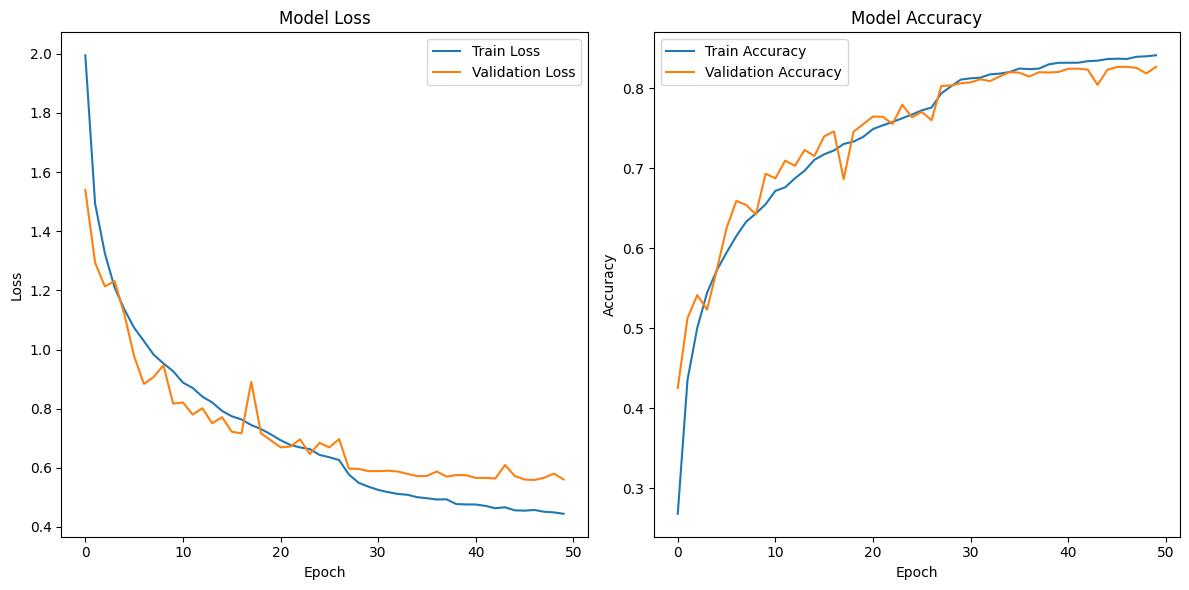

In [ ]:
plt.figure(figsize=(12, 6))

# Plot training & validation loss values
plt.subplot(1, 2, 1)
plt.plot(history2.history['loss'], label='Train Loss')
plt.plot(history2.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training & validation accuracy values
plt.subplot(1, 2, 2)
plt.plot(history2.history['accuracy'], label='Train Accuracy')
plt.plot(history2.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import classification_report

# Make predictions on the validation set
y_pred_prob = model2.predict(X_val)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_val, axis=1)

# Print the classification report
print(classification_report(y_true, y_pred))


314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
              precision    recall  f1-score   support

           0       0.81      0.81      0.81      1440
           1       0.99      1.00      0.99      1467
           2       0.81      0.73      0.77      1425
           3       0.87      0.80      0.83      1474
           4       0.72      0.76      0.74      1379
           5       0.68      0.74      0.71      1398
           6       0.91      0.95      0.93      1447

    accuracy                           0.83     10030
   macro avg       0.83      0.83      0.83     10030
weighted avg       0.83      0.83      0.83     10030



314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


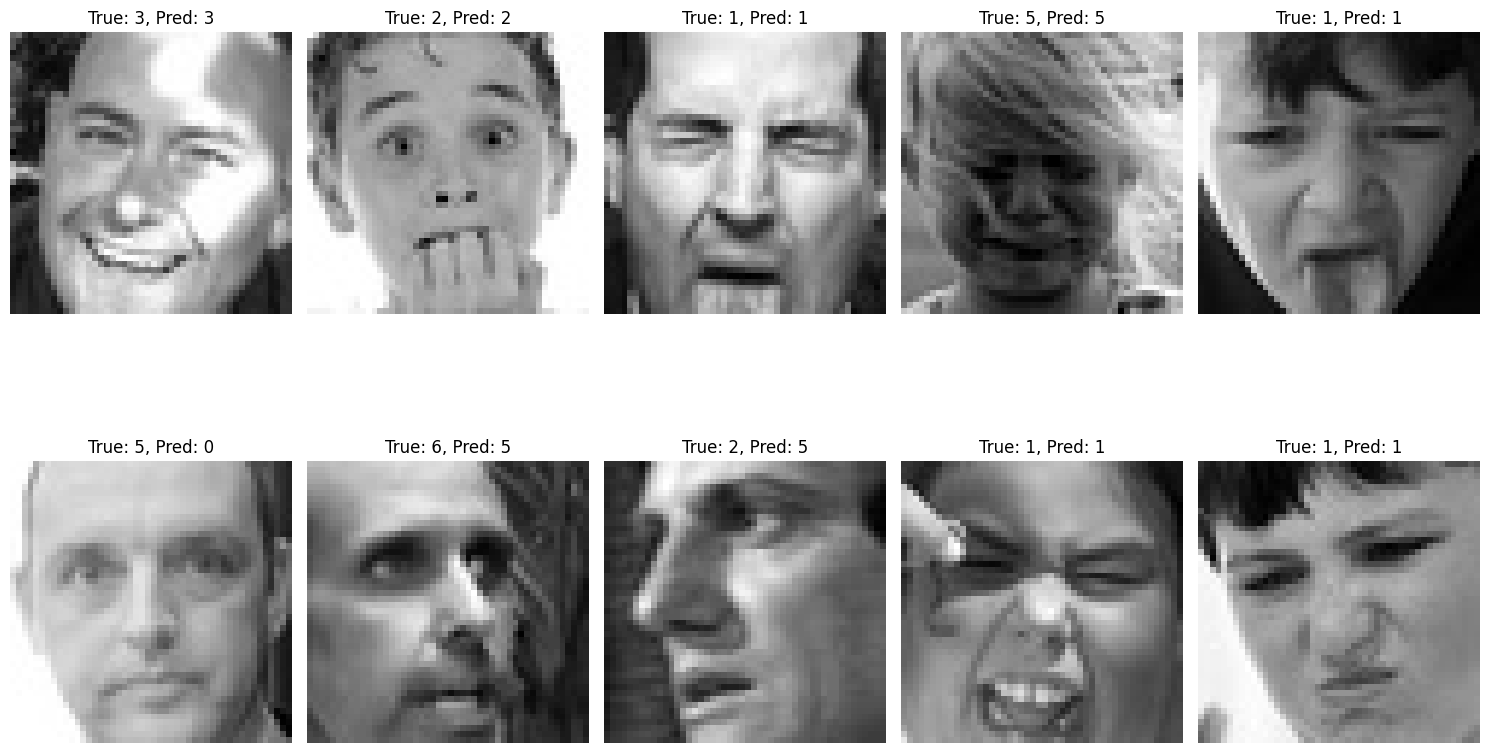

In [ ]:
# prompt: true vs predict images

import matplotlib.pyplot as plt

# Get the predicted labels for the validation set
y_pred_prob = model2.predict(X_val)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_val, axis=1)

# Create a figure to display the images
plt.figure(figsize=(15, 10))

# Iterate through a few examples from the validation set
num_examples_to_show = 10  # You can change this to show more or fewer examples
for i in range(num_examples_to_show):
    plt.subplot(2, 5, i + 1)
    plt.imshow(X_val[i].reshape(48, 48), cmap='gray')
    plt.title(f"True: {y_true[i]}, Pred: {y_pred[i]}")
    plt.axis('off')

plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
test_images, test_labels = load_images_and_labels('/content/images/validation')
test_images_resized = resize_images(test_images)
test_images_normalized = test_images_resized / 255.0
test_labels_numeric = [label_to_numeric[label] for label in test_labels]
test_labels_categorical = to_categorical(test_labels_numeric, num_classes)

# Evaluate the model on the test set
loss, accuracy = model2.evaluate(test_images_normalized.reshape(-1, 48, 48, 1), test_labels_categorical, verbose=0)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

# Make predictions on the test set
y_pred_prob = model2.predict(test_images_normalized.reshape(-1, 48, 48, 1))
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(test_labels_categorical, axis=1)

# Print the classification report
print(classification_report(y_true, y_pred))


Test Loss: 1.2300502061843872
Test Accuracy: 0.6157656311988831
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
              precision    recall  f1-score   support

           0       0.54      0.53      0.54       960
           1       0.71      0.60      0.65       111
           2       0.51      0.39      0.44      1018
           3       0.83      0.81      0.82      1825
           4       0.53      0.56      0.54      1216
           5       0.45      0.54      0.49      1139
           6       0.73      0.77      0.75       797

    accuracy                           0.62      7066
   macro avg       0.61      0.60      0.60      7066
weighted avg       0.62      0.62      0.62      7066



221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


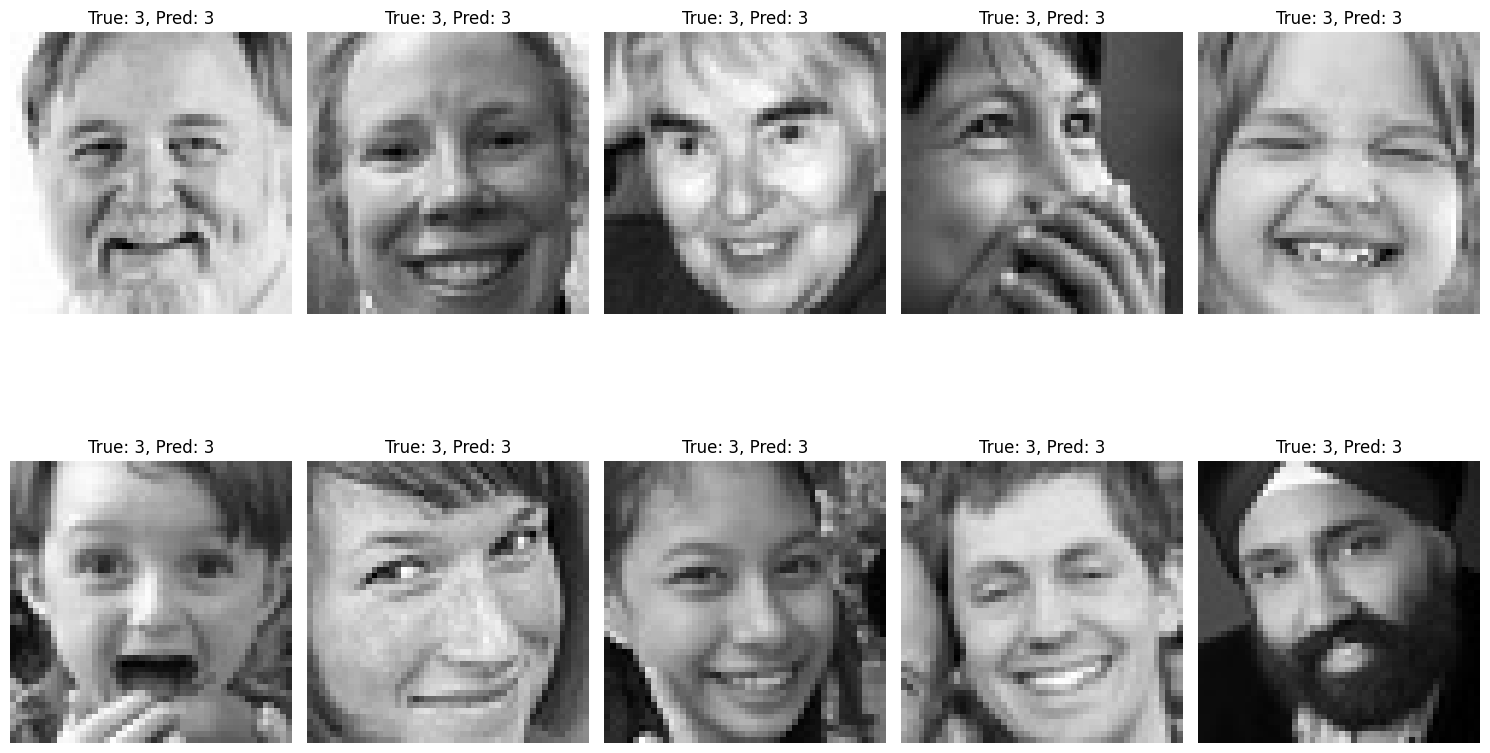

In [ ]:

# Get the predicted labels for the test set
y_pred_prob = model2.predict(test_images_normalized.reshape(-1, 48, 48, 1))
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(test_labels_categorical, axis=1)

# Create a figure to display the images
plt.figure(figsize=(15, 10))

# Iterate through a few examples from the test set
num_examples_to_show = 10  # You can change this to show more or fewer examples
for i in range(num_examples_to_show):
    plt.subplot(2, 5, i + 1)
    plt.imshow(test_images_normalized[i].reshape(48, 48), cmap='gray')
    plt.title(f"True: {y_true[i]}, Pred: {y_pred[i]}")
    plt.axis('off')

plt.tight_layout()
plt.show()
